In [102]:
import olefile
import xmltodict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Read Methods File

In [4]:
!pwd

/c/Users/delgrosso/PycharmProjects/XCaliburMethodReader/notebooks


In [5]:
meth_file = olefile.OleFileIO('../data/test.meth')
meth_file

In [6]:
meth_file.listdir()

[['AuditData'],
 ['LCQ Header'],
 ['Proxeon_EASY-nLC', 'Data'],
 ['Proxeon_EASY-nLC', 'Text'],
 ['Thermo Exactive', 'Data'],
 ['Thermo Exactive', 'Text']]

In [18]:
print(meth_file.openstream(['Proxeon_EASY-nLC', 'Text']).read().decode('utf-16'))

Sample pickup:
Volume [µl]         :     2.50
Flow [µl / min]     :    10.00

Sample loading:
Volume [µl]         :     5.00
Flow [µl / min]     : (unspecified)
Max. pressure [Bar] :   950.00

Gradient:
   Time [mm:ss]   Duration [mm:ss]   Flow [nl/min]   Mixture [%B]
         00:00              00:00             300              5
         95:00              95:00             300             30
         100:00              05:00             300             60
         105:00              05:00             300             95
         110:00              05:00             300             95
         115:00              05:00             300              5
         120:00              05:00             300              5

Pre-column equilibration:
Volume [µl]         :     0.00
Flow [µl / min]     : (unspecified)
Max. pressure [Bar] : (unspecified)

Analytical column equilibration:
Volume [µl]         :     4.00
Flow [µl / min]     : (unspecified)
Max. pressure [Bar] :   950.00

Autosamp

## Extract LC Data

In [12]:
lc_stream = [name for name in meth_file.listdir() if len(name) == 2 and 'LC' in name[0] and 'Data' in name[1]]
assert len(lc_stream) == 1
lc_stream = lc_stream[0]
lc_data = meth_file.openstream(lc_stream).read().decode('utf-8')
lc_data = lc_data[lc_data.index('<?xml'):]
lc_data

'<?xml version="1.0" encoding="UTF-8"?>\r\n<method><owner>Thermo</owner><name>XCalibur Method</name><description>XCalibur Method</description><sampleLoadingFlow>10</sampleLoadingFlow><sampleLoadingVolume>2.5</sampleLoadingVolume><desaltingFlow>Not set</desaltingFlow><desaltingVolume>5</desaltingVolume><desaltingMaxPressure>950</desaltingMaxPressure><reEquilibrationPreColumnFlow>Not set</reEquilibrationPreColumnFlow><reEquilibrationPreColumnVolume>0</reEquilibrationPreColumnVolume><reEquilibrationPreColumnMaxPressure>Not set</reEquilibrationPreColumnMaxPressure><reEquilibrationAnalyticalColumnFlow>Not set</reEquilibrationAnalyticalColumnFlow><reEquilibrationAnalyticalColumnVolume>4</reEquilibrationAnalyticalColumnVolume><reEquilibrationAnalyticalColumnMaxPressure>950</reEquilibrationAnalyticalColumnMaxPressure><washFlushVolume>Not set</washFlushVolume><isWashCyclesEnabled>true</isWashCyclesEnabled><washcycles><methodwashcycle><order>0</order><source>1</source><volume>20</volume><cycles>

## Convert to a Python Dict

In [23]:
lc = xmltodict.parse(lc_data)
lc

OrderedDict([('owner', 'Thermo'),
             ('name', 'XCalibur Method'),
             ('description', 'XCalibur Method'),
             ('sampleLoadingFlow', '10'),
             ('sampleLoadingVolume', '2.5'),
             ('desaltingFlow', 'Not set'),
             ('desaltingVolume', '5'),
             ('desaltingMaxPressure', '950'),
             ('reEquilibrationPreColumnFlow', 'Not set'),
             ('reEquilibrationPreColumnVolume', '0'),
             ('reEquilibrationPreColumnMaxPressure', 'Not set'),
             ('reEquilibrationAnalyticalColumnFlow', 'Not set'),
             ('reEquilibrationAnalyticalColumnVolume', '4'),
             ('reEquilibrationAnalyticalColumnMaxPressure', '950'),
             ('washFlushVolume', 'Not set'),
             ('isWashCyclesEnabled', 'true'),
             ('washcycles',
              OrderedDict([('methodwashcycle',
                            [OrderedDict([('order', '0'),
                                          ('source', '1'),
      

## Calculate Gradient

In [57]:
gradient = pd.DataFrame(lc['gradients']['methodgradient'])
gradient = gradient.astype(int)
gradient.set_index('order', inplace=True)
gradient

,duration,flow,percentB
order,,,
0,0,300,5
1,5700,300,30
2,300,300,60
3,300,300,95
4,300,300,95
5,300,300,5
6,300,300,5


In [58]:
gradient['time'] = gradient['duration'].cumsum()
gradient['time (min)'] = gradient['time'] / 60
gradient

,duration,flow,percentB,time,time (min)
order,,,,,
0,0,300,5,0,0.0
1,5700,300,30,5700,95.0
2,300,300,60,6000,100.0
3,300,300,95,6300,105.0
4,300,300,95,6600,110.0
5,300,300,5,6900,115.0
6,300,300,5,7200,120.0


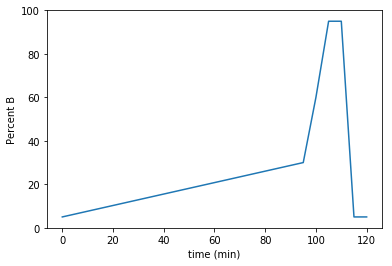

In [59]:
gradient.plot.line(x='time (min)', y='percentB', ylim=[0, 100], legend=False);
plt.ylabel('Percent B');

## Make Table of Other LC Settings (Volume, Flow Rate, and Max Pressure for each stage)

In [67]:
lcp = {key: val for key, val in lc.items() if not 'wash' in key and any(['Flow' in key, 'Volume' in key, 'MaxPressure' in key])}
lcp

{'sampleLoadingFlow': '10',
 'sampleLoadingVolume': '2.5',
 'desaltingFlow': 'Not set',
 'desaltingVolume': '5',
 'desaltingMaxPressure': '950',
 'reEquilibrationPreColumnFlow': 'Not set',
 'reEquilibrationPreColumnVolume': '0',
 'reEquilibrationPreColumnMaxPressure': 'Not set',
 'reEquilibrationAnalyticalColumnFlow': 'Not set',
 'reEquilibrationAnalyticalColumnVolume': '4',
 'reEquilibrationAnalyticalColumnMaxPressure': '950'}

In [71]:
prefixes = [key[:-4] for key in lcp if 'Flow' in key]
prefixes

['sampleLoading',
 'desalting',
 'reEquilibrationPreColumn',
 'reEquilibrationAnalyticalColumn']

In [111]:
data = []
for prefix in prefixes:
    dd = {'step': prefix}
    for value in ['Volume', 'Flow', 'MaxPressure']:
        try:
            dd[value] = lcp[prefix + value]
        except KeyError:
            pass
    data.append(dd)

df = pd.DataFrame(data)
df.set_index('step', inplace=True, )
df.replace('Not set', np.nan, inplace=True)
df = df.astype(float)
df.fillna('', inplace=True)

df

,Flow,MaxPressure,Volume
step,,,
sampleLoading,10,,2.5
desalting,,950,5.0
reEquilibrationPreColumn,,,0.0
reEquilibrationAnalyticalColumn,,950,4.0


## Make Table for Wash Cycles

In [88]:
df = pd.DataFrame(lc['washcycles']['methodwashcycle'])
df.set_index('order', inplace=True)
df

,source,volume,cycles
order,,,
0,1,20,2
1,3,20,2
